In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

We are following Cramer's book (Mathematical Methods of Statistics, 1999)
and computing the estimates for the mean and variance as the
samples mean and population variance of the *grouped sample*.
More precisely:
$$\mu_* = \frac{1}{n} \sum_{j=1}^k N_j \xi_j$$
and
$$\sigma^2_* = \frac{1}{n} \sum_{j=1}^k N_j {(\xi_j - \mu_*)}^2$$
where the $\xi_j$'s are equally spaced such that
**all** observations lie between $\xi_2$ and $\xi_{k-1}$
(i.e. the two most extreme interval do not contain any observations).

In [2]:
# Auxiliary function
def is_in_interval(number, interval):
    lower_bound, upper_bound = interval
    return lower_bound < number < upper_bound

In [5]:
def goodness_of_fit_normal_test(data, k):
    """
    k: number of groups to use for the data
    """

    # Record the number of samples
    n = len(data)
    
    # Dimension of the parameter space
    # (this function only works for a Normal model)
    s = 2

    # Create k groups of equal length.
    # The first group ENDS at min - offset,
    # the last group STARTS at max+offset.
    # (We use the offset to make sure that the
    # two most extreme groups are empty.)
    offset = data.std()
    min_data = min(data)
    max_data = max(data)
    group_size = (max_data+offset - (min_data-offset))/(k-2)

    # Each group is a 2-tuple of the form
    # (lower_bound, upper_bound)
    groups = [
        (
            min_data-offset-group_size + j*group_size,
            min_data-offset-group_size + (j+1)*group_size
        )
        for j in range(k)
    ]

    # Compute the centers xi_j
    group_centers = [
        (lower_bound + upper_bound)/2
        for lower_bound, upper_bound in groups
    ]

    # Count how many samples appear in each group
    group_counts = [
        sum(is_in_interval(xi, group)for xi in data)
        for group in groups
    ]

    # Estimate the mean (according to the formula above)
    mu_estimate = sum(
        group_counts[j]*group_centers[j]
        for j in range(k)
    )/n

    # Estimate the variance (according to the formula above)
    var_estimate = sum(
        group_counts[j]*(group_centers[j]-mu_estimate)**2
        for j in range(k)
    )/n

    # Estimate the standard deviation
    std_estimate = np.sqrt(var_estimate)

    # Estimated distribution
    dist_estimate = scipy.stats.norm(loc=mu_estimate, scale=std_estimate)

    # Compute the expected group counts
    # (E_j = n*p_j in the notes)
    expected_group_counts = [
        n*(
            dist_estimate.cdf(upper_bound) - dist_estimate.cdf(lower_bound)
        )
        for lower_bound, upper_bound in groups
    ]

    # Compute the test statistic
    test_statistic = sum(
        (group_counts[j] - expected_group_counts[j])**2 / expected_group_counts[j]
        for j in range(k) if expected_group_counts[j] != 0
    )

    # Compute the pvalue
    pvalue = scipy.stats.chi2(df=k-1-s).sf(test_statistic)
    
    return pvalue

### Plotting the pvalue when the null hypothesis is true

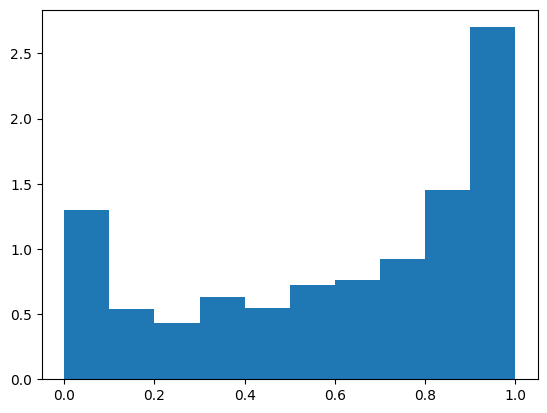

In [56]:
trials = 1000

pvalues = [
    goodness_of_fit_normal_test(
        data = scipy.stats.norm.rvs(loc=0, scale=1, size=1000),
        k=50
    )
    for _ in range(trials)
]

plt.hist(pvalues, density=True)
plt.show()

### Plotting the pvalues when testing samples from a t-distribution

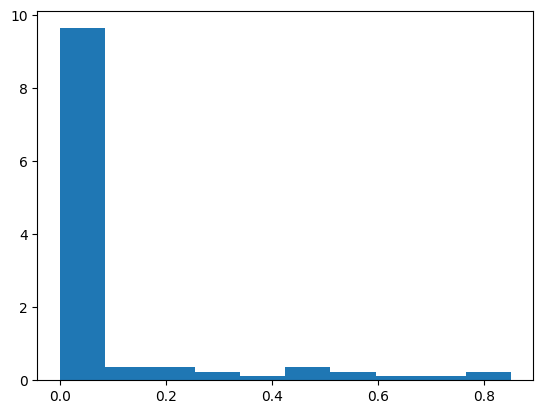

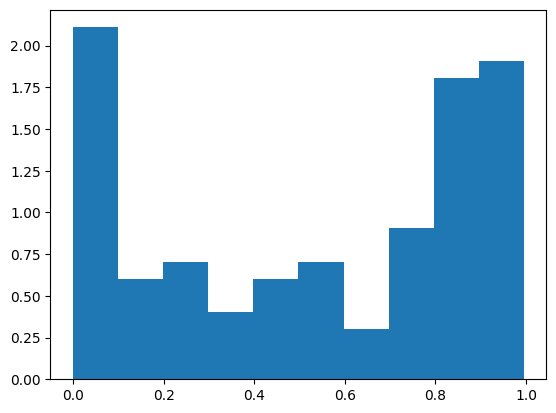

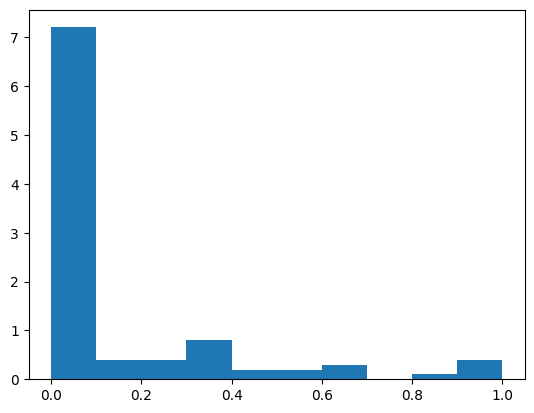

In [81]:
trials = 100

# Case 1: few degrees of freedom

pvalues = [
    goodness_of_fit_normal_test(
        data = scipy.stats.t.rvs(df=3, size=100),
        k=10
    )
    for _ in range(trials)
]

plt.hist(pvalues, density=True)
plt.show()

# Case 2: high degrees of freedom

pvalues = [
    goodness_of_fit_normal_test(
        data = scipy.stats.t.rvs(df=10, size=100),
        k=10
    )
    for _ in range(trials)
]

plt.hist(pvalues, density=True)
plt.show()

# Case 2: high degrees of freedom, higher number of samples

pvalues = [
    goodness_of_fit_normal_test(
        data = scipy.stats.t.rvs(df=10, size=500),
        k=50
    )
    for _ in range(trials)
]

plt.hist(pvalues, density=True)
plt.show()

##### Plotting the distributions in each case to see if, at the naked eye, we can tell which one is **not** Normal.
In each case we also plot a Normal distribution with mean and variance
estimate from $X$.

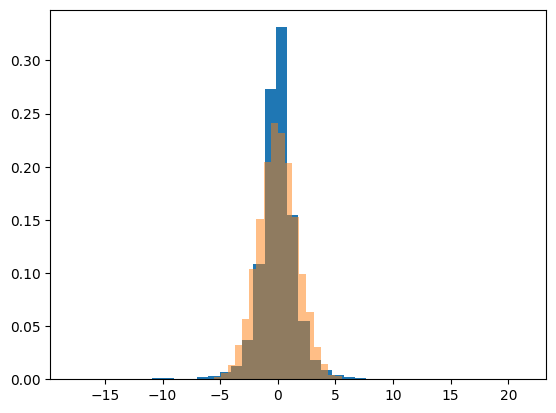

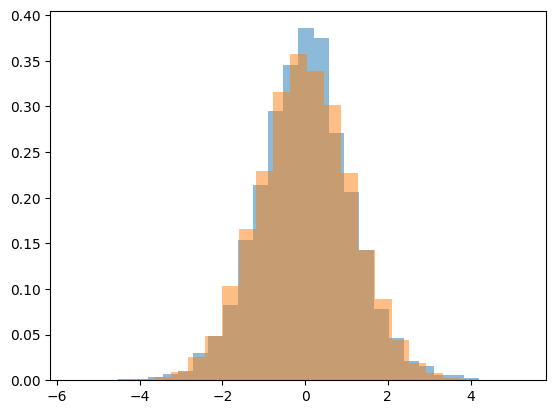

In [102]:
# Case 1

X = scipy.stats.t.rvs(df=3, size=10000)
plt.hist(X, density=True, bins=40)

Y = scipy.stats.norm.rvs(loc=X.mean(), scale=X.std(), size=10000)
plt.hist(Y, density=True, bins=20, alpha=0.5)

plt.show()

# Case 2

X = scipy.stats.t.rvs(df=10, size=10000)
plt.hist(X, density=True, bins=30, alpha=0.5)

Y = scipy.stats.norm.rvs(loc=X.mean(), scale=X.std(), size=10000)
plt.hist(Y, density=True, bins=20, alpha=0.5)

plt.show()

### Plotting the pvalues when testing samples from an exponentially modified Normal

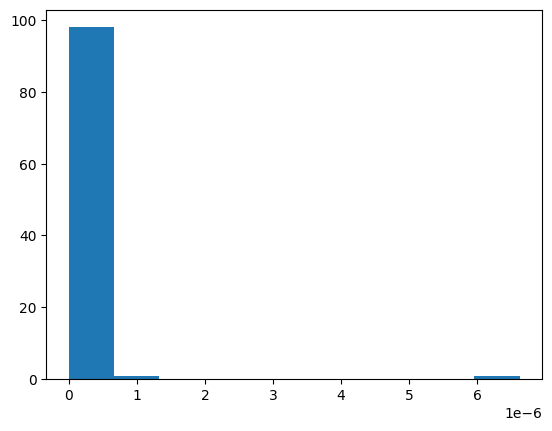

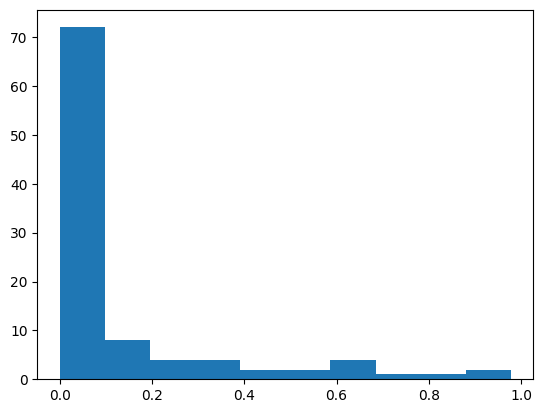

In [92]:
trials = 100

# Case 1: high K

pvalues = [
    goodness_of_fit_normal_test(
        data = scipy.stats.exponnorm.rvs(K=3, size=200),
        k=15
    )
    for _ in range(trials)
]

plt.hist(pvalues)
plt.show()

# Case 2: low K

pvalues = [
    goodness_of_fit_normal_test(
        data = scipy.stats.exponnorm.rvs(K=1.001, size=200),
        k=15
    )
    for _ in range(trials)
]

plt.hist(pvalues)
plt.show()